In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
from tqdm import tqdm
import numpy as np
import seaborn as sns

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#Unagumented
df = pd.read_csv('./Unaug_Data/HAM10000_Metadata')

In [4]:
#Unagumented
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0.0


In [5]:
df['risk'].value_counts()

1.0    6705
3.0    1627
0.0    1356
2.0     327
Name: risk, dtype: int64

# Separate Data into Even Baskets and Testing Set

In [6]:
df0 = df.loc[df["risk"] == 0]
df1 = df.loc[df["risk"] == 1] 
df2 = df.loc[df["risk"] == 2] 
df3 = df.loc[df["risk"] == 3] 

#Randomly Shuffle rows
df0 = df0.sample(frac = 1).reset_index(drop = True)
df1 = df1.sample(frac = 1).reset_index(drop = True)
df2 = df2.sample(frac = 1).reset_index(drop = True)
df3 = df3.sample(frac = 1).reset_index(drop = True)

In [7]:
#Separate Training and Testing Dataset; select last 20 elements from each class as testing dataframe
test_df = df0.iloc[-20:, :]
test_df = test_df.append(df1.iloc[-20:,:])
test_df = test_df.append(df2.iloc[-20:, :])
test_df = test_df.append(df3.iloc[-20:, :])

In [8]:
#Drop last 20 elements from training dataframe
df0 = df0.iloc[:-20,:]
df1 = df1.iloc[:-20,:]
df2 = df2.iloc[:-20,:]
df3 = df3.iloc[:-20,:]

In [9]:
count = 265
basket = 1
start = 0
total_df = df0.iloc[start: basket*count,:]
while basket < 6:
    total_df = total_df.append(df1.iloc[start:basket*count, :], ignore_index = True)
    total_df = total_df.append(df2.iloc[0:265, :], ignore_index = True)
    total_df = total_df.append(df3.iloc[start:basket*count, :], ignore_index = True)
    basket = basket + 1
    start += 265
    total_df = total_df.append(df0.iloc[start:basket*count, :], ignore_index = True)
total_df = total_df.iloc[:-11, :]

In [ ]:
total_df

In [ ]:
total_df['risk'].value_counts()

In [ ]:
pd.options.display.max_columns = 2000

# Preprocessing and Training Models

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.001,
  patience=3, restore_best_weights=True)

## Separate input and output into five fold

In [11]:
Basket = 1060
df1 = total_df.iloc[0:Basket, :]
df2 = total_df.iloc[Basket:2*Basket, :]
df3 = total_df.iloc[2*Basket: 3*Basket, :]
df4 = total_df.iloc[3*Basket:4*Basket, :]
df5 = total_df.iloc[4*Basket:5*Basket, :]

df1 = df1.sample(frac = 1).reset_index(drop = True)
df2= df2.sample(frac = 1).reset_index(drop = True)
df3 = df3.sample(frac = 1).reset_index(drop = True)
df4 = df4.sample(frac = 1).reset_index(drop = True)
df5 = df5.sample(frac = 1).reset_index(drop = True)
test_df = test_df.sample(frac = 1).reset_index(drop = True)

In [12]:
NUM_VAL = 80
NUM_TRN = 1060
TOTAL = 1060

In [13]:
test_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,HAM_0002011,ISIC_0031711,mel,histo,55.0,female,lower extremity,vidir_modern,3.0
1,HAM_0004883,ISIC_0031851,bkl,histo,55.0,male,back,rosendahl,0.0
2,HAM_0004746,ISIC_0029021,mel,histo,65.0,female,back,rosendahl,3.0
3,HAM_0004397,ISIC_0025589,mel,histo,55.0,female,neck,vidir_modern,3.0
4,HAM_0005154,ISIC_0024762,nv,consensus,55.0,male,back,vidir_modern,1.0
...,...,...,...,...,...,...,...,...,...
75,HAM_0003144,ISIC_0032135,akiec,histo,65.0,female,face,rosendahl,2.0
76,HAM_0003001,ISIC_0032514,bkl,histo,75.0,male,face,vidir_modern,0.0
77,HAM_0003025,ISIC_0027440,nv,follow_up,35.0,female,trunk,vidir_molemax,1.0
78,HAM_0004472,ISIC_0025368,akiec,histo,40.0,female,face,rosendahl,2.0


## VGG Model Setup

### Testing Dataset

In [14]:
# VGG-16
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 80)):
    file = test_df.iloc[i]['image_id']
    #feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(preds)#np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:08<00:00,  9.67it/s]


In [15]:
VGG_X_val = np.array(VGG_X)
del VGG_X

In [32]:
y_val = np.array(test_df['risk'])

In [20]:
risk = []
for ele in test_df['risk']:
    risk.append(tf.one_hot(int(ele),4))
y_val = np.array(risk)
y_val.shape

(80, 4)

In [33]:
new_y_val = []
for ele in y_val:
    new_y_val.append(ele)
    
new_y_val = np.array(new_y_val)

new_y_val.shape

(80,)

In [22]:
new_VGG_val = []

for i in tqdm(range(0, NUM_VAL)):
    new_VGG_val.append(np.array(VGG_X_val[i]))

new_VGG_val = np.array(new_VGG_val)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 17786.61it/s]


In [19]:
y_val

array([3., 0., 3., 3., 1., 0., 1., 0., 0., 3., 0., 3., 3., 2., 3., 2., 2.,
       2., 3., 2., 1., 2., 0., 1., 1., 1., 3., 3., 3., 1., 2., 2., 3., 1.,
       0., 3., 2., 2., 1., 2., 0., 1., 3., 0., 0., 0., 3., 1., 2., 0., 0.,
       1., 2., 1., 2., 3., 2., 1., 3., 1., 1., 3., 1., 0., 0., 2., 3., 0.,
       3., 0., 2., 1., 0., 2., 1., 2., 0., 1., 2., 0.])

### Basket 1

In [23]:
# VGG-16
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 1060)):
    file = df1.iloc[i]['image_id']
    #feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(preds)#np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [01:02<00:00, 16.94it/s]


In [24]:
y_trn = np.array(df1['risk'])

In [25]:
VGG_X_trn = np.array(VGG_X)

del VGG_X

In [26]:
new_y_trn = []
for ele in y_trn:
    new_y_trn.append(ele)
    
new_y_trn = np.array(new_y_trn)

new_y_trn.shape

(1060,)

In [27]:
new_VGG_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

100%|████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 8783.73it/s]


In [28]:
new_VGG_trn.shape

(1060, 100352)

In [47]:
vgg_model1 = models.Sequential()
#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model1.add(layers.Dense(2048, activation='tanh'))
vgg_model1.add(layers.BatchNormalization())
vgg_model1.add(layers.Dense(1024, activation='tanh'))
vgg_model1.add(layers.BatchNormalization())
vgg_model1.add(layers.Dense(512, activation='tanh'))
vgg_model1.add(layers.BatchNormalization())
vgg_model1.add(layers.Dense(128, activation='tanh'))
vgg_model1.add(layers.Dense(4))

In [48]:
new_y_trn.shape

(1060,)

In [49]:
vgg_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model1.fit(new_VGG_trn, new_y_trn, 
              epochs=10, 
              validation_data=(new_VGG_val, new_y_val),
              batch_size = 8,
              callbacks=[earlystop_callback])

Epoch 1/10
133/133 [==============================] - 3s 18ms/step - loss: 10.0080 - accuracy: 0.2566 - val_loss: 9.6648 - val_accuracy: 0.2250
Epoch 2/10
133/133 [==============================] - 2s 17ms/step - loss: 9.5933 - accuracy: 0.2377 - val_loss: 9.9108 - val_accuracy: 0.2000
Epoch 3/10
133/133 [==============================] - 2s 17ms/step - loss: 9.3716 - accuracy: 0.2311 - val_loss: 9.6556 - val_accuracy: 0.2875
Epoch 4/10
133/133 [==============================] - 2s 17ms/step - loss: 9.2732 - accuracy: 0.2481 - val_loss: 9.7763 - val_accuracy: 0.2375
Epoch 5/10
133/133 [==============================] - 2s 17ms/step - loss: 9.1672 - accuracy: 0.2151 - val_loss: 9.6425 - val_accuracy: 0.2625
Epoch 6/10
133/133 [==============================] - 2s 17ms/step - loss: 9.0951 - accuracy: 0.2160 - val_loss: 9.5152 - val_accuracy: 0.2500


In [ ]:
#Save vgg model
vgg_model1.save("VGG_P1.h5")

In [50]:
predict_y_vgg_val_1 = []
#temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val_1 = vgg_model1.predict(new_VGG_val)

#del new_VGG_trn
#del new_VGG_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_vgg_val_1[i])
    predict_y_vgg_val_1.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<?, ?it/s]


In [51]:
predict_y_vgg_val_1

[1,
 1,
 1,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 3,
 2,
 3,
 0,
 0,
 3,
 1,
 1,
 2,
 3,
 2,
 2,
 3,
 0,
 2,
 2,
 2,
 0,
 3,
 2,
 3,
 3,
 1,
 3,
 0,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 0,
 3,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 2,
 3,
 3,
 0,
 2,
 1,
 3,
 1,
 0,
 1,
 2,
 3,
 0,
 3,
 3,
 3,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0]

In [46]:
y_val

array([3., 0., 3., 3., 1., 0., 1., 0., 0., 3., 0., 3., 3., 2., 3., 2., 2.,
       2., 3., 2., 1., 2., 0., 1., 1., 1., 3., 3., 3., 1., 2., 2., 3., 1.,
       0., 3., 2., 2., 1., 2., 0., 1., 3., 0., 0., 0., 3., 1., 2., 0., 0.,
       1., 2., 1., 2., 3., 2., 1., 3., 1., 1., 3., 1., 0., 0., 2., 3., 0.,
       3., 0., 2., 1., 0., 2., 1., 2., 0., 1., 2., 0.])

### Basket 2

In [35]:
# VGG-16
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 1060)):
    file = df2.iloc[i]['image_id']
    #feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(preds)#np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [01:03<00:00, 16.62it/s]


In [36]:
y_trn = np.array(df2['risk'])


VGG_X_trn = np.array(VGG_X)


del VGG_X



new_y_trn = []
for ele in y_trn:
    new_y_trn.append(ele)
    
new_y_trn = np.array(new_y_trn)


new_VGG_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

100%|████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 7085.54it/s]


In [37]:
vgg_model2 = models.Sequential()

#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model2.add(layers.Dense(2048, activation='tanh'))
vgg_model2.add(layers.BatchNormalization())
vgg_model2.add(layers.Dense(1024, activation='tanh'))
vgg_model2.add(layers.BatchNormalization())
vgg_model2.add(layers.Dense(512, activation='tanh'))
vgg_model2.add(layers.BatchNormalization())
vgg_model2.add(layers.Dense(128, activation='tanh'))
vgg_model2.add(layers.BatchNormalization())
vgg_model2.add(layers.Dense(4))

vgg_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model2.fit(new_VGG_trn, new_y_trn, 
              epochs=30, 
              validation_data=(new_VGG_val, new_y_val),
              batch_size = 8,
              callbacks=[earlystop_callback])

Epoch 1/30
133/133 [==============================] - 3s 19ms/step - loss: 10.3834 - accuracy: 0.2491 - val_loss: 9.3716 - val_accuracy: 0.3000
Epoch 2/30
133/133 [==============================] - 2s 18ms/step - loss: 9.4722 - accuracy: 0.2594 - val_loss: 10.1210 - val_accuracy: 0.2750
Epoch 3/30
133/133 [==============================] - 2s 18ms/step - loss: 9.0948 - accuracy: 0.2472 - val_loss: 9.1054 - val_accuracy: 0.2125
Epoch 4/30
133/133 [==============================] - 2s 18ms/step - loss: 8.8596 - accuracy: 0.2632 - val_loss: 9.4624 - val_accuracy: 0.2750


In [38]:
#Save vgg model
vgg_model2.save("VGG_P2.h5")

In [39]:
predict_y_vgg_val_2 = []
#temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val_2 = vgg_model2.predict(new_VGG_val)

#del new_VGG_trn
#del new_VGG_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_vgg_val_2[i])
    predict_y_vgg_val_2.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<?, ?it/s]


In [40]:
predict_y_vgg_val_2

[1,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 3,
 2,
 1,
 0,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 3,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 1,
 3,
 1,
 1,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2]

### Basket 3

In [52]:
# VGG-16
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 1060)):
    file = df3.iloc[i]['image_id']
    #feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(preds)#np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

  0%|                                                                                         | 0/1060 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [01:00<00:00, 17.49it/s]


In [53]:
y_trn = np.array(df3['risk'])


VGG_X_trn = np.array(VGG_X)


del VGG_X



new_y_trn = []
for ele in y_trn:
    new_y_trn.append(ele)
    
new_y_trn = np.array(new_y_trn)


new_VGG_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

100%|████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 8856.94it/s]


In [65]:
vgg_model3 = models.Sequential()
#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model3.add(layers.Dense(2048, activation='relu'))
vgg_model2.add(layers.BatchNormalization())
vgg_model3.add(layers.Dense(1024, activation='relu'))
vgg_model2.add(layers.BatchNormalization())
vgg_model3.add(layers.Dense(512, activation='relu'))
vgg_model2.add(layers.BatchNormalization())
vgg_model3.add(layers.Dense(128, activation='relu'))
vgg_model3.add(layers.Dense(4))

vgg_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model3.fit(new_VGG_trn, new_y_trn, 
              epochs=30, 
              validation_data=(new_VGG_val, new_y_val), 
              callbacks=[earlystop_callback])

Epoch 1/30
34/34 [==============================] - 1s 21ms/step - loss: 11.0549 - accuracy: 0.2698 - val_loss: 10.0212 - val_accuracy: 0.2375
Epoch 2/30
34/34 [==============================] - 1s 19ms/step - loss: 17.6872 - accuracy: 0.2594 - val_loss: 36.2834 - val_accuracy: 0.2625
Epoch 3/30
34/34 [==============================] - 1s 18ms/step - loss: 99.5561 - accuracy: 0.2594 - val_loss: 264.2057 - val_accuracy: 0.2500
Epoch 4/30
34/34 [==============================] - 1s 19ms/step - loss: 685.0918 - accuracy: 0.2547 - val_loss: 1963.3142 - val_accuracy: 0.2500
Epoch 5/30
34/34 [==============================] - 1s 18ms/step - loss: 1499.3347 - accuracy: 0.2538 - val_loss: 1346.1414 - val_accuracy: 0.2500


In [ ]:
#Save vgg model
vgg_model3.save("VGG_P3.h5")

In [66]:
predict_y_vgg_val_3 = []
#temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val_3 = vgg_model3.predict(new_VGG_val)

#del new_VGG_trn
#del new_VGG_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_vgg_val_3[i])
    predict_y_vgg_val_3.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 80216.19it/s]


In [67]:
predict_y_vgg_val_3

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2]

### Basket 4

In [68]:
# VGG-16
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 1060)):
    file = df4.iloc[i]['image_id']
    #feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(preds)#np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

  0%|                                                                                         | 0/1060 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [01:02<00:00, 16.94it/s]


In [69]:
y_trn = np.array(df4['risk'])


VGG_X_trn = np.array(VGG_X)


del VGG_X



new_y_trn = []
for ele in y_trn:
    new_y_trn.append(ele)
    
new_y_trn = np.array(new_y_trn)


new_VGG_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

100%|████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 7564.35it/s]


In [71]:
vgg_model4 = models.Sequential()
#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model4.add(layers.Dense(2048, activation='relu'))
vgg_model2.add(layers.BatchNormalization())
vgg_model4.add(layers.Dense(1024, activation='relu'))
vgg_model2.add(layers.BatchNormalization())
vgg_model4.add(layers.Dense(512, activation='relu'))
vgg_model2.add(layers.BatchNormalization())
vgg_model4.add(layers.Dense(128, activation='relu'))
vgg_model4.add(layers.Dense(4))

vgg_model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model4.fit(new_VGG_trn, new_y_trn, 
              epochs=30, 
              validation_data=(new_VGG_val, new_y_val), 
              callbacks=[earlystop_callback])

Epoch 1/30


ResourceExhaustedError: in user code:

    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:858 train_function  *
        return step_function(self, iterator)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:847 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3652 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:840 run_step  **
        outputs = model.train_step(data)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:792 train_step
        y_pred = self(x, training=True)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\sequential.py:383 call
        outputs = layer(inputs, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:1030 __call__
        self._maybe_build(inputs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:2659 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\layers\core.py:1178 build
        self.kernel = self.add_weight(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:647 add_weight
        variable = self._add_variable_with_custom_getter(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\tracking\base.py:813 _add_variable_with_custom_getter
        new_variable = getter(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer_utils.py:117 make_variable
        return tf.compat.v1.Variable(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:266 __call__
        return cls._variable_v1_call(*args, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:212 _variable_v1_call
        return previous_getter(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3567 creator
        return next_creator(**kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3567 creator
        return next_creator(**kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3567 creator
        return next_creator(**kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\def_function.py:746 variable_capturing_scope
        v = UnliftedInitializerVariable(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py:270 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\eager\def_function.py:294 __init__
        initial_value = initial_value()
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\initializers\initializers_v2.py:517 __call__
        return self._random_generator.random_uniform(shape, -limit, limit, dtype)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\keras\initializers\initializers_v2.py:972 random_uniform
        return op(
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\random_ops.py:315 random_uniform
        result = math_ops.add(result * (maxval - minval), minval, name=name)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_ops.py:3943 add
        return gen_math_ops.add_v2(x, y, name=name)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:454 add_v2
        _ops.raise_from_not_ok_status(e, name)
    C:\Users\15521\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:7023 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: failed to allocate memory [Op:AddV2]


In [ ]:
#Save vgg model
vgg_model4.save("VGG_P4.h5")

In [ ]:
predict_y_vgg_val_4 = []
#temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val_4 = vgg_model4.predict(new_VGG_val)

#del new_VGG_trn
#del new_VGG_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_vgg_val_4[i])
    predict_y_vgg_val_4.append(pred)

### Basket 5

In [ ]:
# VGG-16
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 1060)):
    file = df5.iloc[i]['image_id']
    #feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(preds)#np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

In [ ]:
y_trn = np.array(df5['risk'])


VGG_X_trn = np.array(VGG_X)


del VGG_X



new_y_trn = []
for ele in y_trn:
    new_y_trn.append(ele)
    
new_y_trn = np.array(new_y_trn)


new_VGG_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

In [ ]:
vgg_model5 = models.Sequential()
#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model5.add(layers.Dense(2048, activation='relu'))
vgg_model5.add(layers.Dense(1024, activation='relu'))
vgg_model5.add(layers.Dense(512, activation='relu'))
vgg_model5.add(layers.Dense(128, activation='relu'))
vgg_model5.add(layers.Dense(4))

vgg_model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model5.fit(new_VGG_trn, new_y_trn, 
              epochs=30, 
              validation_data=(new_VGG_val, new_y_val), 
              callbacks=[earlystop_callback])

In [ ]:
#Save vgg model
vgg_model5.save("VGG_P5.h5")

In [ ]:
predict_y_vgg_val_5 = []
#temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val_5 = vgg_model5.predict(new_VGG_val)

#del new_VGG_trn
#del new_VGG_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_vgg_val_5[i])
    predict_y_vgg_val_5.append(pred)

# Ensemble Five Models

### Average Method

In [77]:
temp_all = []
for i in range(0, NUM_VAL):
    temp_all.append((temp_vgg_val_1[i]+temp_vgg_val_2[i]+temp_vgg_val_3[i])/3)#+temp_vgg_val_4[i]+temp_vgg_val_5[i]))
temp_all = np.array(temp_all)

In [78]:
predict_y_final_val = []

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_all[i])
    predict_y_final_val.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<?, ?it/s]


In [79]:
cm_final = tf.math.confusion_matrix(np.array(test_df['risk']), np.array(predict_y_final_val))

cm_final = np.array(cm_final).astype('float32')

cm_final[0] = cm_final[0] / (1.0 * cm_final[0].sum())
cm_final[1] = cm_final[1] / (1.0 * cm_final[1].sum())
cm_final[2] = cm_final[2] / (1.0 * cm_final[2].sum())
cm_final[3] = cm_final[3] / (1.0 * cm_final[3].sum())

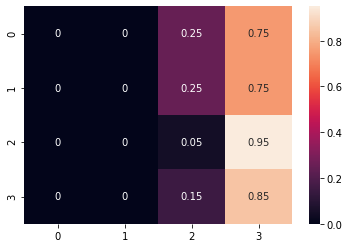

In [88]:
svm = sns.heatmap(cm_final, annot=True)

In [89]:
#Save final pic
figure = svm.get_figure()
figure.savefig(r"A:\Deep Learning\Term Project\Pic\Ensemble-Resnet-no adjustment\final.png", dpi = 400)

In [ ]:
predict_y_vgg_val_5

In [90]:
cm_model1 = tf.math.confusion_matrix(np.array(test_df['risk']), np.array(predict_y_vgg_val_1))
cm_model1 = np.array(cm_model1).astype('float32')

cm_model2 = tf.math.confusion_matrix(np.array(test_df['risk']), np.array(predict_y_vgg_val_2))
cm_model2 = np.array(cm_model2).astype('float32')

cm_model3 = tf.math.confusion_matrix(np.array(test_df['risk']), np.array(predict_y_vgg_val_3))
cm_model3 = np.array(cm_model3).astype('float32')

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2]

In [91]:
cm_model1[0] = cm_model1[0] / (1.0 * cm_model1[0].sum())
cm_model1[1] = cm_model1[1] / (1.0 * cm_model1[1].sum())
cm_model1[2] = cm_model1[2] / (1.0 * cm_model1[2].sum())
cm_model1[3] = cm_model1[3] / (1.0 * cm_model1[3].sum())

cm_model2[0] = cm_model2[0] / (1.0 * cm_model2[0].sum())
cm_model2[1] = cm_model2[1] / (1.0 * cm_model2[1].sum())
cm_model2[2] = cm_model2[2] / (1.0 * cm_model2[2].sum())
cm_model2[3] = cm_model2[3] / (1.0 * cm_model2[3].sum())

cm_model3[0] = cm_model3[0] / (1.0 * cm_model3[0].sum())
cm_model3[1] = cm_model3[1] / (1.0 * cm_model3[1].sum())
cm_model3[2] = cm_model3[2] / (1.0 * cm_model3[2].sum())
cm_model3[3] = cm_model3[3] / (1.0 * cm_model3[3].sum())

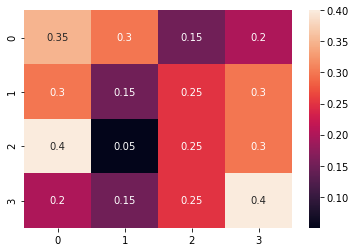

In [93]:
svm1 = sns.heatmap(cm_model1, annot=True);

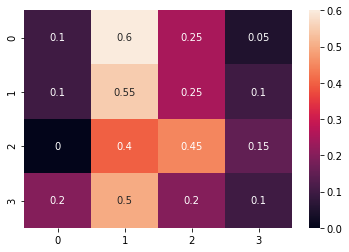

In [101]:
svm2 = sns.heatmap(cm_model2, annot=True);


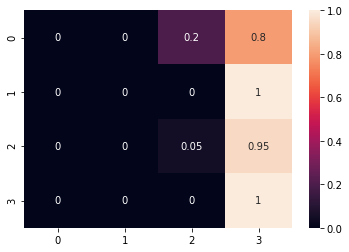

In [102]:
svm3 = sns.heatmap(cm_model3, annot=True);

In [87]:
figure1 = svm1.get_figure()
figure1.savefig(r"A:\Deep Learning\Term Project\Pic\Ensemble-Resnet-no adjustment\model1.png", dpi = 400)

In [103]:
figure2 = svm2.get_figure()
figure2.savefig(r"A:\Deep Learning\Term Project\Pic\Ensemble-Resnet-no adjustment\model2.png", dpi = 400)

In [104]:
figure3 = svm3.get_figure()
figure3.savefig(r"A:\Deep Learning\Term Project\Pic\Ensemble-Resnet-no adjustment\model3.png", dpi = 400)